In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
class FoodStorage:

    def __init__(self, startingInsectFood, startingLegacyFood, percentInsect):
        """
        Args:
        startingInsectFood (int): amount of insect food in kg.
        startingLegacyFood (int): amount of "legacy" food in kg.
        percentInsect (float)   : percentage of insectfood in animalfeed.
        """
        self.co2PerInsect = 1
        self.co2PerLegacy = 2
        self.insectFood = startingInsectFood
        self.legacyFood = startingLegacyFood
        self.percentInsect = percentInsect
        self.totalFood = self.insectFood + self.legacyFood
        self.minFood = (self.totalFood, currentDate)

    def eatFood(self, eaten):
        """
        Args:
        eaten (int/float): Amount eaten in kg .
        
        Returns: 
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = 0
        if self.insectFood >= eaten*self.percentInsect:
            self.insectFood -= eaten*self.percentInsect
            self.legacyFood -= eaten*(1-self.percentInsect)
            co2 += eaten*self.percentInsect*self.co2PerInsect
            co2 += eaten*(1-self.percentInsect)*self.co2PerLegacy
        else:
            self.legacyFood -= eaten
            co2 = eaten*self.co2PerLegacy
        self.totalFood = self.insectFood + self.legacyFood
        if self.totalFood < self.minFood[0]:
            self.minFood = (self.totalFood, currentDate)
        return co2
        
    def addInsectFood(self, add):
        """
        Args:
        add (int): amount of insectfood added to storage.
        """
        self.insectFood += add
        
    def addLegacyFood(self, add):
        """
        Args:
        add (int): amount of "legacy" food added to storage.
        """
        self.legacyFood += add

In [3]:
class InsectFarm:
    def __init__(self, sqrMeter, insectType, target):
        """
        Args:
        sqrMeter (int): Size of sqr. meters for insectfarm.
        insectType (string): Type of insect ("bi" or "larve").
        target (FoodStorage obj.): Where to put harvested insects.
        """
        insects = {'bi': (1, 14), 'larve': (5, 14)}
        self.nutrition = insects[insectType][0]*sqrMeter
        self.harvestFrequency = datetime.timedelta(days=insects[insectType][1])
        self.nextHarvest = currentDate + self.harvestFrequency
        self.target = target
        self.consumption = 1*sqrMeter
        
    def harvest(self):
        """
        Return:
        self.nutrition (int/float): Amount harvested in kg.
        """
        self.target.addInsectFood(self.nutrition)
        self.nextHarvest = currentDate + self.harvestFrequency
        return self.nutrition

In [8]:
class Piggery:
    def __init__(self, noPigs, nutritionNeeds, sellDate, target):
        """
        Args:
        noPigs (int): Amount of pigs in farm.
        nutritionNeeds (float): Food per pig per day (kg).
        sellDate (int): Days untill pig is sold.
        target (FoodStorage obj.): Where to eat from.
        """
        self.noPigs = noPigs
        self.nutritionNeeds = noPigs*nutritionNeeds
        self.sellDate = currentDate + datetime.timedelta(days=sellDate)
        self.target = target
        
    def eat(self):
        """
        Return:
        self.nutritionNeeds (float): Food eaten (kg).
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = self.target.eatFood(self.nutritionNeeds)
        return self.nutritionNeeds,co2

In [18]:
###############Settings####################
startdate = '01Jan2019'                     
stopdate = '01Jan2020'                      
legacyFillUp = datetime.timedelta(days=7)
legacyFillUpAmount = 30
###########################################

currentDate = datetime.datetime.strptime(startdate, '%d%b%Y')
stopDate = datetime.datetime.strptime(stopdate, '%d%b%Y')
refillDate = currentDate + legacyFillUp

food = FoodStorage(startingInsectFood=11, startingLegacyFood=40, percentInsect=0.6)
farm = InsectFarm(sqrMeter=11, insectType='larve', target=food)
piggery = Piggery(noPigs=1, nutritionNeeds=10, sellDate=60, target=food)

df = pd.DataFrame(columns=['Month', 'Consumption', 'Harvest','CO2Emission'])
df = df.set_index('Month')

while currentDate != stopDate:
    # Add month/year(Sep19) row if not already present.
    if currentDate.strftime("%b%y") not in df.index.tolist():
        df.loc[currentDate.strftime("%b%y")] = [0,0,0]
    
    if currentDate == refillDate:
        food.addLegacyFood(legacyFillUpAmount)      
    
    if currentDate == farm.nextHarvest:
        df.loc[currentDate.strftime("%b%y")].Harvest += farm.harvest()
    
    consumption,co2 = piggery.eat()
    df.loc[currentDate.strftime("%b%y")].Consumption += consumption
    df.loc[currentDate.strftime("%b%y")].CO2Emission += co2
    
    currentDate = currentDate+datetime.timedelta(days=1)

14 days, 0:00:00
2019-01-15 00:00:00


In [19]:
df

,Consumption,Harvest,CO2Emission
Month,,,
Jan19,310,110,536
Feb19,280,110,452
Mar19,310,110,494
Apr19,300,110,474
May19,310,110,506
Jun19,300,110,492
Jul19,310,165,494
Aug19,310,110,494
Sep19,300,110,480


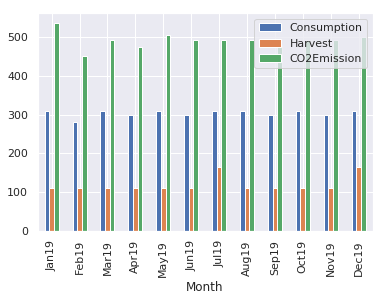

In [104]:
sns.set()
df.plot(kind='bar', stacked=False)

In [21]:
class Piggery:
    def __init__(self, startNoPiglets, startNoPigs, pigletNutritionNeeds, pigNutritionNeeds,
                 gestationTime,pigletTime, sellFrequency,litters, target, currentDate):
        """
        Args:
        noPigs (int): Amount of pigs in farm.
        nutritionNeeds (float): Food per pig per day (kg).
        sellDate (int): Days untill pig is sold.
        target (FoodStorage obj.): Where to eat from.
        
        # https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0141878.s001
        # Link with info regarding pig gestation
        """
        self.piglets = []
        self.pigs = []
        self.noPiglets = 0
        self.noPigs = 0
        self.startNoPiglets = startNoPiglets
        
        self.gestationFrequency = datetime.timedelta(int((gestationTime+pigletTime)/litters))
        self.pigletTime = datetime.timedelta(pigletTime)
        self.nextLitter = currentDate
        self.sellFrequency = datetime.timedelta(sellFrequency)
        self.pigletNutritionNeeds = pigletNutritionNeeds
        self.pigNutritionNeeds = pigNutritionNeeds
        self._addPiglets(startNoPiglets,currentDate)
        self._addPigs(startNoPigs,currentDate)
        self._updateNoPigs()
        self._updateNoPiglets()
        #self.piglets
        #self.pigs = [(startNoPigs,currentDate + self.sellFrequency)]
        self.lastUpdateDate = currentDate
        self.target = target

        
                
    def _addPiglets(self, noPiglets,currentDate):
        
        if currentDate == self.nextLitter or currentDate > self.nextLitter:
        
            self.piglets.append((noPiglets,currentDate + self.pigletTime))
            
            self.nextLitter = currentDate+ self.gestationFrequency
            
        
    
    def _addPigs(self,noPigs,currentDate):
        self.pigs.append((noPigs,currentDate + self.sellFrequency))
        #self.addPiglets(self.noPiglets)
        #self.newPigletsDate = currentDate + self.gestation
    
    def _movePiglets(self,currentDate):
        
        noPiglets = 0
        for i,litter in enumerate(self.piglets):
            if currentDate == litter[1] or currentDate > litter[1]:
                noPiglets += litter[0]
                self.piglets.pop(i)
                
        self._addPigs(noPiglets,currentDate)
        
    def _sellPigs(self, currentDate):
        
        for i,litter in enumerate(self.pigs):
            if currentDate == litter[1]:
                self.pigs.pop(i)
        

    def _eat(self,currentDate):
        """
        Return:
        self.nutritionNeeds (float): Food eaten (kg).
        co2 (float): CO2 emission from eaten amount.
        """
        days = (currentDate - self.lastUpdateDate).days
        pigletEat = self.noPiglets * self.pigletNutritionNeeds* days
        pigEat = self.noPigs * self.pigNutritionNeeds* days
        amountEaten = pigletEat+pigEat 
        co2 = self.target.eatFood(amountEaten)
        
        self.lastUpdateDate = currentDate
                
        return amountEaten, co2
                
    def _updateNoPigs(self):
        noPigs = 0
        for litter in self.pigs:
              noPigs +=litter[0]
                
        self.noPigs = noPigs
                
    def _updateNoPiglets(self):
        noPiglets = 0
        for litter in self.piglets:
              noPiglets +=litter[0]
                
        self.noPiglets = noPiglets
    
    def update(self,currentDate):
        
        eaten,co2 = self._eat(currentDate)
        
        self._addPiglets(self.startNoPiglets,currentDate)
        self._movePiglets(currentDate)
        self._sellPigs(currentDate)
        self._updateNoPigs()
        self._updateNoPiglets()
        
        
        return eaten,co2,self.noPiglets,self.noPigs

In [22]:
###############Settings####################
startdate = '01Jan2019'                     
stopdate = '01Jan2020'

### Food ###
startingInsectFood=11
startingLegacyFood=40
percentInsect=0.6

### Insect farm ###
sqrMeter=11
insectType='larve'

#### Piggery ###
startNoPiglets=10      # Number of piglets at day 0
startNoPigs=10         # Number of pigs at day 0
pigletNutritionNeeds=5 # Piglets nutrition needs
pigNutritionNeeds=4    # Pigs nutrition needs
gestationTime=115      # Frequency of gestation (115 days(gestation) + 4.5 weeks(baby))
pigletTime = 32        # 
litters = 2            # Amount of pigs producing piglets (presumed to be out of sync litters)
sellFrequency=84       # Time pigs need to be fed before they are sold 
###########################################

currentDate = datetime.datetime.strptime(startdate, '%d%b%Y')
stopDate = datetime.datetime.strptime(stopdate, '%d%b%Y')


food = FoodStorage(startingInsectFood, startingLegacyFood, percentInsect)
farm = InsectFarm(sqrMeter, insectType, target=food)
piggery = Piggery(startNoPiglets, startNoPigs, pigletNutritionNeeds, pigNutritionNeeds, 
                  gestationTime,pigletTime, sellFrequency,litters, target=food,currentDate=currentDate)

df = pd.DataFrame(columns=['Month', 'Piglets', 'Pigs','AmountEaten','co2'])
df = df.set_index('Month')

while currentDate != stopDate and currentDate < stopDate:
    
    eaten,co2,piglets,pigs = piggery.update(currentDate)
    
    # Add month/year(Sep19) row if not already present.
    if currentDate.strftime("%d%b%y") not in df.index.tolist():
        df.loc[currentDate.strftime("%d%b%y")] = [0,0,0,0]
        
    df.loc[currentDate.strftime("%d%b%y")].Piglets += piglets
    df.loc[currentDate.strftime("%d%b%y")].Pigs += pigs
    df.loc[currentDate.strftime("%d%b%y")].AmountEaten += eaten
    df.loc[currentDate.strftime("%d%b%y")].co2 += co2
    
    currentDate = currentDate+datetime.timedelta(days=7)

In [23]:
df

,Piglets,Pigs,AmountEaten,co2
Month,,,,
01Jan19,10,10,0,0
08Jan19,10,10,630,1260
15Jan19,10,10,630,1260
22Jan19,10,10,630,1260
29Jan19,10,10,630,1260
05Feb19,0,20,630,1260
12Feb19,0,20,560,1120
19Feb19,0,20,560,1120
26Feb19,0,20,560,1120


In [96]:
eaten

(14560, 29120)

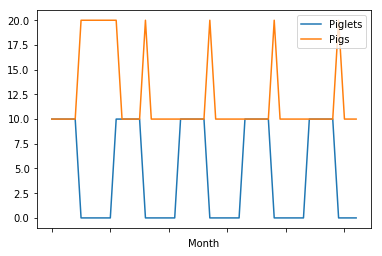

In [24]:
df[['Piglets', 'Pigs']].plot()